In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("../../")
print(os.getcwd())

C:\Users\Milosz\Desktop\python\thesis-recsys


In [2]:
import pandas as pd
import numpy as np
import functools
import operator
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [67]:
games = pd.read_csv('data/games.csv')
rec = pd.read_csv('data/recommendations.csv')
users = pd.read_csv('data/users.csv')
meta = pd.read_json("data/games_metadata.json", lines=True)

In [4]:
meta

,app_id,description,tags
0,10090,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,,[Action]
3,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
...,...,...,...
48348,248410,The planet of Aethereus is an ancient and myst...,"[RPG, Action, Indie, Multiplayer, Co-op, Kicks..."
48349,839680,"No, Pay to Win/ Yes, Original Military FPS OBT...","[Free to Play, FPS, PvP, War, Combat, Modern, ..."
48350,758210,Look for hints and disable the bomb. Now!! You...,"[Adventure, Early Access, Simulation, VR, Esca..."
48351,1612360,As a new Pvt on camp Greenwood you will be tes...,"[Action, Simulation, Racing, Shooter, FPS, VR,..."


In [5]:
games

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck
0,10090,Call of Duty: World at War,2008-11-18,True,False,False,Very Positive,92,37039,19.99,19.99,0.0,True
1,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True
2,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True
3,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True
4,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48348,248410,Legends of Aethereus,2013-09-27,True,True,True,Mostly Negative,23,142,0.00,0.00,0.0,True
48349,839680,The Front of Greed,2018-08-01,True,False,False,Mostly Negative,37,27,0.00,0.00,0.0,True
48350,758210,Escape Room,2017-12-11,True,False,False,Mostly Negative,23,30,0.00,0.00,0.0,True
48351,1612360,Pistol Master!,2021-05-20,True,False,False,Negative,18,11,0.00,0.00,0.0,True


In [6]:
rec

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
0,975370,0,0,2022-12-12,True,36.3,21265,0
1,304390,4,0,2017-02-17,False,11.5,1166,1
2,1085660,2,0,2019-11-17,True,336.5,97101,2
3,703080,0,0,2022-09-23,True,27.4,99068,3
4,526870,0,0,2021-01-10,True,7.9,9721,4
...,...,...,...,...,...,...,...,...
11480207,311690,0,0,2020-09-17,True,16.1,3250115,11480207
11480208,1449850,0,0,2022-02-01,False,0.7,42845,11480208
11480209,960090,3,0,2020-11-26,True,200.2,190650,11480209
11480210,311690,0,0,2018-01-07,True,5.7,4429817,11480210


In [7]:
users

,user_id,products,reviews
0,6104846,156,1
1,3841247,329,3
2,2074781,176,2
3,2236937,98,2
4,2476707,144,3
...,...,...,...
6230639,2137695,3,0
6230640,2140035,0,0
6230641,2141140,0,0
6230642,2141972,0,0


In [8]:
def plot_monthly_interactions(df: pd.DataFrame, col: str, boundary: str = None):
    """
    Plot interactions from `df[col]` aggregated per month as line chart.
    
    Args:
        df: Dataset containing `col`
        col: Name of column with dates 
        boundary: Date in format `yyyy-mm-dd` representing boundary of split
    """
    
    fig, ax = plt.subplots()
    
    month_ints = pd.to_datetime(df[col]).dt.to_period("M").value_counts().sort_index()
    #month_ints = df[col].str.slice(0, 7).value_counts().sort_index()
    month_ints.index = month_ints.index.to_timestamp()
    
    ax.plot(month_ints)
    
    if boundary:
        from datetime import datetime
        boundary = datetime.strptime("2022-12-01", "%Y-%m-%d")
        ax.axvline(boundary, color='red', linestyle='--')
        
    plt.show()

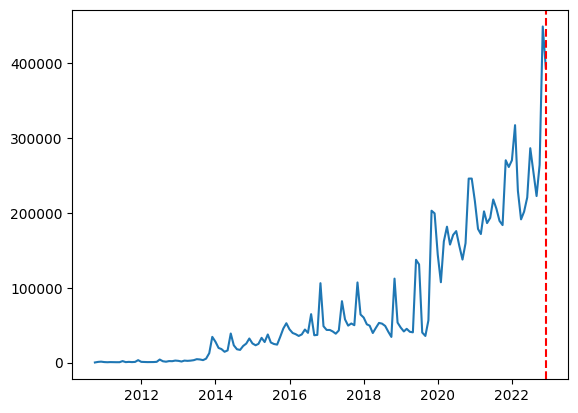

In [9]:
plot_monthly_interactions(rec, "date", "2022-12-01")

In [10]:
rec['is_recommended'] = rec['is_recommended'].astype(float)

In [11]:
rec = rec[rec['is_recommended'] == 1.0]

In [12]:
def split_by_time(df: pd.DataFrame, col: str, split_point = None):
    """
    Sort and split dataframe into train and test sets on given split point.
    
    Args:
        df: Dataset containing `col`
        split_date: Split date in format `yyyy-mm-dd`
        col: Name of column with dates
        
    Returns:
        Tuple of (train_set, test_set) where train contains rows before `date`
    """
    df_sorted = df.sort_values(by=col)
    
    if isinstance(split_point, str):
        mask = df_sorted[col] <= split_date
    elif isinstance(split_point, float):
        mask = np.concatenate([np.ones(int(df_sorted.shape[0] * split_point)),
                               np.zeros(df_sorted.shape[0]-int(df_sorted.shape[0] * split_point))]).astype(bool)
        
    df_train = df_sorted[mask]
    df_test = df_sorted[~mask]
    
    return df_train, df_test

In [13]:
rec_train, rec_test = split_by_time(df=rec, col="date", split_point=0.7)

In [14]:
def split_transductive(df_train, df_test, user_col='user_id', item_col='app_id', print_stats=False):
    all_users, all_items = df_train[user_col].unique(), df_train[item_col].unique()
    
    df_test_trans = df_test[(df_test[user_col].isin(all_users)) & \
                            (df_test[item_col].isin(all_items))]
    
    if print_stats:
        u_test, i_test = df_test[user_col].unique().size, df_test[item_col].unique().size
        u_test_trans, i_test_trans = df_test_trans[user_col].unique().size, \
                                     df_test_trans[item_col].unique().size
        
        print(f"Train User nodes: {all_users.size} \nTrain Item nodes: {all_items.size} \n\n\
Test User nodes w/o intersection: {u_test} \nTest Item nodes w/o intersection: \
{i_test} \n\nTest User nodes: {u_test_trans} \nTest Item nodes: {i_test_trans}")
        
    return df_train, df_test_trans

In [15]:
rec_train, rec_test = split_transductive(rec_train, rec_test, print_stats=True)

Train User nodes: 4092474 
Train Item nodes: 1483 

Test User nodes w/o intersection: 2102235 
Test Item nodes w/o intersection: 1863 

Test User nodes: 520936 
Test Item nodes: 1464


In [16]:
rec_train

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
6288229,8930,0,0,2010-10-15,1.0,403.6,319225,6288229
10368645,45700,0,0,2010-10-15,1.0,126.6,3001180,10368645
10262775,1200,0,0,2010-10-15,1.0,6.5,319225,10262775
11071048,33930,0,0,2010-10-15,1.0,276.5,4877354,11071048
5973921,550,8,0,2010-10-15,1.0,128.0,3217208,5973921
...,...,...,...,...,...,...,...,...
4887719,686810,0,0,2021-12-15,1.0,567.8,6192394,4887719
6628752,1557740,0,0,2021-12-15,1.0,15.0,5881843,6628752
7661959,1211020,9,0,2021-12-15,1.0,25.9,1357166,7661959
7942522,1235140,0,0,2021-12-15,1.0,48.4,1770902,7942522


In [17]:
rec_test

,app_id,helpful,funny,date,is_recommended,hours,user_id,review_id
6291762,860510,0,0,2021-12-15,1.0,5.2,1326785,6291762
10527692,1275350,0,0,2021-12-15,1.0,8.1,496472,10527692
7660575,996580,0,0,2021-12-15,1.0,13.9,4040568,7660575
9515794,528230,0,0,2021-12-15,1.0,3.4,5081715,9515794
5133081,1174180,0,0,2021-12-15,1.0,67.1,88580,5133081
...,...,...,...,...,...,...,...,...
8682903,1066780,0,0,2022-12-31,1.0,64.1,2691397,8682903
9436594,861650,0,0,2022-12-31,1.0,0.7,2164254,9436594
2399038,1203220,0,0,2022-12-31,1.0,13.3,2967549,2399038
4817632,1174180,0,0,2022-12-31,1.0,75.8,29715,4817632


In [18]:
def remap(df, col):
    idx = df[col].unique()
    new_idx = np.arange(idx.size)
    return {i: ni for i, ni in zip(idx, new_idx)}

In [19]:
user_dict = remap(rec_train, 'user_id')
item_dict = remap(rec_train, 'app_id')

In [20]:
rec_train['user_id'] = rec_train['user_id'].map(user_dict)
rec_train['app_id'] = rec_train['app_id'].map(item_dict)

rec_test['user_id'] = rec_test['user_id'].map(user_dict)
rec_test['app_id'] = rec_test['app_id'].map(item_dict)

In [ ]:
rec_test.groupby('user_id').apply(lambda x: display(x[['user_id', 'app_id', 'date', 'is_recommended']]))

### Save train and test relation graph and objects mappings

In [22]:
rec_train[['user_id', 'app_id', 'date', 'is_recommended']].to_csv("data/graph_train.csv")
rec_test[['user_id', 'app_id', 'date', 'is_recommended']].to_csv("data/graph_test.csv")

pd.DataFrame.from_dict(user_dict, orient='index').to_csv("data/user_dict.csv")
pd.DataFrame.from_dict(item_dict, orient='index').to_csv("data/item_dict.csv")

### Extract `tags` from games included in training graph by one-hot encoding them and saving indices as list

In [ ]:
from utils import *

In [ ]:
train_df = load_data_from_csv("data/graph_train.csv")
test_df = load_data_from_csv("data/graph_test.csv")

In [ ]:
item_dict = load_data_from_csv("data/item_dict.csv").to_dict()['0']

In [48]:
meta

,app_id,description,tags
0,10090,"Call of Duty is back, redefining war like you'...","[Zombies, World War II, FPS, Multiplayer, Acti..."
1,13500,Enter the dark underworld of Prince of Persia ...,"[Action, Adventure, Parkour, Third Person, Gre..."
2,22364,,[Action]
3,113020,Monaco: What's Yours Is Mine is a single playe...,"[Co-op, Stealth, Indie, Heist, Local Co-Op, St..."
4,226560,Escape Dead Island is a Survival-Mystery adven...,"[Zombies, Adventure, Survival, Action, Third P..."
...,...,...,...
48348,248410,The planet of Aethereus is an ancient and myst...,"[RPG, Action, Indie, Multiplayer, Co-op, Kicks..."
48349,839680,"No, Pay to Win/ Yes, Original Military FPS OBT...","[Free to Play, FPS, PvP, War, Combat, Modern, ..."
48350,758210,Look for hints and disable the bomb. Now!! You...,"[Adventure, Early Access, Simulation, VR, Esca..."
48351,1612360,As a new Pvt on camp Greenwood you will be tes...,"[Action, Simulation, Racing, Shooter, FPS, VR,..."


In [68]:
meta['app_id'] = meta['app_id'].map(item_dict)

In [69]:
apps_attributes = meta.dropna()
apps_attributes['app_id'] = apps_attributes['app_id'].astype(int)
apps_attributes = apps_attributes.sort_values(by=['app_id'])

C:\Users\Milosz\AppData\Local\Temp\ipykernel_30284\1741919556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apps_attributes['app_id'] = apps_attributes['app_id'].astype(int)


In [70]:
apps_attributes

,app_id,description,tags
9695,0,"Create, discover, and download new player-crea...","[Turn-Based Strategy, Strategy, Turn-Based, Mu..."
17005,1,Devil May Cry® 4 immerses gamers in a gothic s...,"[Action, Hack and Slash, Character Action Game..."
11952,2,Fight in the theatre of war that changed the w...,"[World War II, Action, FPS, Realistic, Multipl..."
13050,3,"Three years after the conflict in Chernarus, p...","[Simulation, Military, Action, Multiplayer, Ta..."
18280,4,"Set in the zombie apocalypse, Left 4 Dead 2 (L...","[Zombies, Co-op, FPS, Multiplayer, Shooter, Ac..."
...,...,...,...
19341,1478,"In the world of A-Train, people gather around ...","[Simulation, Trains, Immersive Sim, City Build..."
19541,1479,A spooky teddy bear first-person shooter where...,"[Early Access, FPS, PvE, Shooter, Character Cu..."
14467,1480,"Design warships the way you want them, command...","[Naval Combat, Naval, Wargame, Military, Build..."
14701,1481,BBQ Simulator lets you experience what barbecu...,"[Simulation, Life Sim, Cooking, Funny, Casual,..."


In [71]:
from sklearn.preprocessing import MultiLabelBinarizer

In [72]:
mlb = MultiLabelBinarizer()
mlb.fit_transform(apps_attributes['tags'])
tag_map = {cat: idx for idx, cat in enumerate(mlb.classes_)}

In [73]:
apps_attributes['tags_id'] = apps_attributes['tags'].apply(lambda x: [tag_map[c] for c in x])

In [ ]:
apps_attributes[['app_id_map', 'tags_id']].to_csv("data/graph_app_tags.csv")

### One-hot encode app features and take app subset used in training graph

In [ ]:
games['app_id_map'] = games['app_id'].map(item_dict)
apps_attributes2 = games.dropna(subset=['app_id_map'])
apps_attributes2['app_id_map'] = apps_attributes2['app_id_map'].astype(int)
apps_attributes2 = apps_attributes2.sort_values(by=['app_id_map'])
apps_attributes2 = apps_attributes2[['app_id_map', 'win', 'mac', 'linux', 'rating', 'positive_ratio', 'user_reviews', 'price_original', 'price_final', 'discount', 'steam_deck']]

In [ ]:
def featurize_apps(df):
    for c in ['win', 'mac', 'linux', 'steam_deck']:
        df[c] = df[c].astype(int)

    rating = pd.get_dummies(df['rating'])
    df = pd.concat([df, rating], axis=1)
   
    cols = ['app_id_map', 'win', 'mac', 'linux', 'steam_deck', 'price_original', 'price_final', 'discount', 'user_reviews', 'positive_ratio'] + \
    list(rating.columns)

    return df[cols]

In [ ]:
apps_attributes2 = featurize_apps(apps_attributes2)

In [ ]:
apps_attributes2.to_csv("data/graph_app_features.csv")

In [79]:
users

,user_id,products,reviews
0,6104846,156,1
1,3841247,329,3
2,2074781,176,2
3,2236937,98,2
4,2476707,144,3
...,...,...,...
6230639,2137695,3,0
6230640,2140035,0,0
6230641,2141140,0,0
6230642,2141972,0,0


### Store `user` and `app` attribute matrices as *pickle (.pkl)* files

In [ ]:
def save_app_attr_as_numpy(path_tags, path_meta, path_save):
    N_TAGS = 425
    N_CAT = 10
    N_CONT = 5
    
    TAGS_COL = ['tags_id']
    CAT_COL = ['win', 'mac', 'linux', 'steam_deck', 'Mixed', 'Mostly Negative', 'Mostly Positive', 'Overwhelmingly Positive', 'Positive', 'Very Positive']
    CONT_COL = ['positive_ratio', 'user_reviews', 'price_original', 'price_final', 'discount']
    
    app_attr_tags = pd.read_csv(path_tags, index_col=[0])
    app_attr_meta = pd.read_csv(path_meta, index_col=[0])
    
    N_APPS = app_attr_tags.shape[0]
    
    attr_matrix = []

    for (i,tags), (i,meta) in zip(app_attr_tags.iterrows(), app_attr_meta.iterrows()):
        tag = np.zeros(N_TAGS)
        idx = np.fromstring(tags[TAGS_COL].values[0][1:-1], dtype=int, sep=',')
        tag[idx] = 1
        
        cat = meta[CAT_COL].values
        cont = meta[CONT_COL].values
        
        v = np.concatenate((tag, cat, cont))
        
        attr_matrix.append(v)
        
    attr_matrix = np.vstack(attr_matrix)
    
    with open(path_save, 'wb') as f:
        pickle.dump(attr_matrix, f)

In [ ]:
save_app_attr_as_numpy(
    path_tags="data/graph_app_tags_stacked.csv",
    path_meta="data/graph_app_features.csv",
    path_save="data/steam_app_attr.pkl"
)

In [ ]:
def save_user_attr_as_numpy(path_meta, path_save):
    N_CONT = 2

    CONT_COL = ['products', 'reviews']
    
    user_attr_meta = pd.read_csv(path_meta, index_col=[0])
    attr_matrix = user_attr_meta[CONT_COL].values
    
    with open(path_save, 'wb') as f:
        pickle.dump(attr_matrix, f)

In [ ]:
save_user_attr_as_numpy(
    path_meta="data/users.csv",
    path_save="data/steam_user_attr.pkl"
)